In [ ]:
import pyspark.sql.functions as F

In [ ]:
#####LOOOOOK HERE######
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("DataExploration").getOrCreate()


path_to_csv_folder = "/content/drive/MyDrive/reddit-data/*"

df = spark.read.option("multiline", "true").option("quote", '"').option("header", "true").option("inferSchema", "true").option("sep", ",").option("escape", "\"").csv(path_to_csv_folder)

df.show()


+----------+-------------------+----------+--------------------+---------------------------+------------------+--------------------------+-------------------+------------------+------------------+------------------+------------------+---------------------+-------+------------+--------------------+--------------------+-------+-----------+--------------+-------+--------------------+-------------------+-------------------+-------------+---------------------+---------------+-------------------+----------+---------------------+-----------------+-----------+-------------+-------------+-------------+----------------+------------+------------------------+----------+------------+---------------------+-----------+--------------------+---------------+---------+--------------+--------------+--------------+-----------------+-----------------+----------+----------------+--------------+-----------+---------+------------+------------+-----------------+-----------+---------+---------+-----------+------

In [ ]:
#Omitting all the feature columns because it was not extracted using my custom functions
selected_df = df.select("subreddit", "author", "date", "post")

selected_df.show()

+----------+-------------------+----------+--------------------+
| subreddit|             author|      date|                post|
+----------+-------------------+----------+--------------------+
|depression|           peeepeed|2020/01/01|My heart aches bu...|
|depression|   cookieexpertuser|2020/01/01|Cheers I’m not su...|
|depression|         Ghostiez23|2020/01/01|Fuck titles. I’m ...|
|depression|           wisqrg50|2020/01/01|suffering from lo...|
|depression|   arizonwatermelon|2020/01/01|I can already tel...|
|depression|ThatBloodyValentine|2020/01/01|I just turned 19 ...|
|depression|     chiefkeith7511|2020/01/01|Is there any way ...|
|depression|        dustin_keel|2020/01/01|Horrid mood swing...|
|depression|         BaIA102037|2020/01/01|ANHEDONIA &amp; e...|
|depression|      bounce-bounce|2020/01/01|Empty I wanted to...|
|depression|    DrowningPilot21|2020/01/01|I'm still here Ca...|
|depression|      emogirl123456|2020/01/01|numb i’m thinking...|
|depression|          cut

In [ ]:
#Number of Rows
selected_df.count()


In [ ]:
#Number of Columns
len(selected_df.columns)

In [ ]:
#Null value count
selected_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in selected_df.columns]).show()

In [ ]:
'''#Remove null values
cleaned_df = selected_df.dropna()

cleaned_df = selected_df.dropna(subset=['subreddit', 'author','date','post'])'''

In [ ]:
#cleaned_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in cleaned_df.columns]).show()

In [ ]:
selected_df.select('subreddit').distinct().count()

In [ ]:
selected_df.select('subreddit').distinct().show()

In [ ]:
selected_df.select('date').distinct().count()

In [ ]:
selected_df.select('date').distinct().show()

In [ ]:
selected_df.describe().show()

In [ ]:
selected_df.dtypes

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

# Count the number of posts in each subreddit
subreddit_counts = selected_df.groupBy('subreddit').count().orderBy('count', ascending=False).cache()

'''Note to self - MORE RESEARCH REQUIRED - How to bypass conversion to pandas for visualization? It seems spark does not have an
exclusive visualization library'''
subreddit_counts_pandas = subreddit_counts.toPandas()

# Plotting
plt.figure(figsize=(10,6))
plt.bar(subreddit_counts_pandas['subreddit'], subreddit_counts_pandas['count'], color='blue')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.title('Distribution of Posts Across Subreddits')
plt.show()



In [ ]:
#Posting trends over time
#Convert date to date time object and analyse posting trends over time
from pyspark.sql.functions import to_date
from pyspark.sql.functions import col
from pyspark.sql.functions import weekofyear, month, year

selected_df = selected_df.withColumn("date", to_date(selected_df.date, "yyyy/MM/dd"))
daily_posts = selected_df.groupBy("date").count().orderBy("date")

# Not the best way to visualize for efficiency
daily_posts_pandas = daily_posts.toPandas()

# Plotting - This command gave such a bad graph, cannot look at it!Figure out a better visualization
#daily_posts_pandas.plot(x='date', y='count')

In [ ]:
plt.figure(figsize=(15, 7))  # Increase figure size
plt.plot(daily_posts_pandas['date'], daily_posts_pandas['count'], marker='o', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Daily Posts Over Time')

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

In [ ]:
#Trying to visualize weekly posting trend
# Aggregate posts by week and year
weekly_posts = selected_df.withColumn("week", weekofyear(col("date"))) \
                          .withColumn("year", year(col("date"))) \
                          .groupBy("year", "week") \
                          .count() \
                          .orderBy("year", "week")


weekly_posts_pandas = weekly_posts.toPandas()

# Plotting
plt.figure(figsize=(15, 7))  # Increase figure size
plt.plot(weekly_posts_pandas['week'], weekly_posts_pandas['count'], marker='o', linestyle='-')
plt.xlabel('Week of the Year')
plt.ylabel('Number of Posts')
plt.title('Weekly Posts Over Time')

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))

plt.tight_layout()
plt.show()


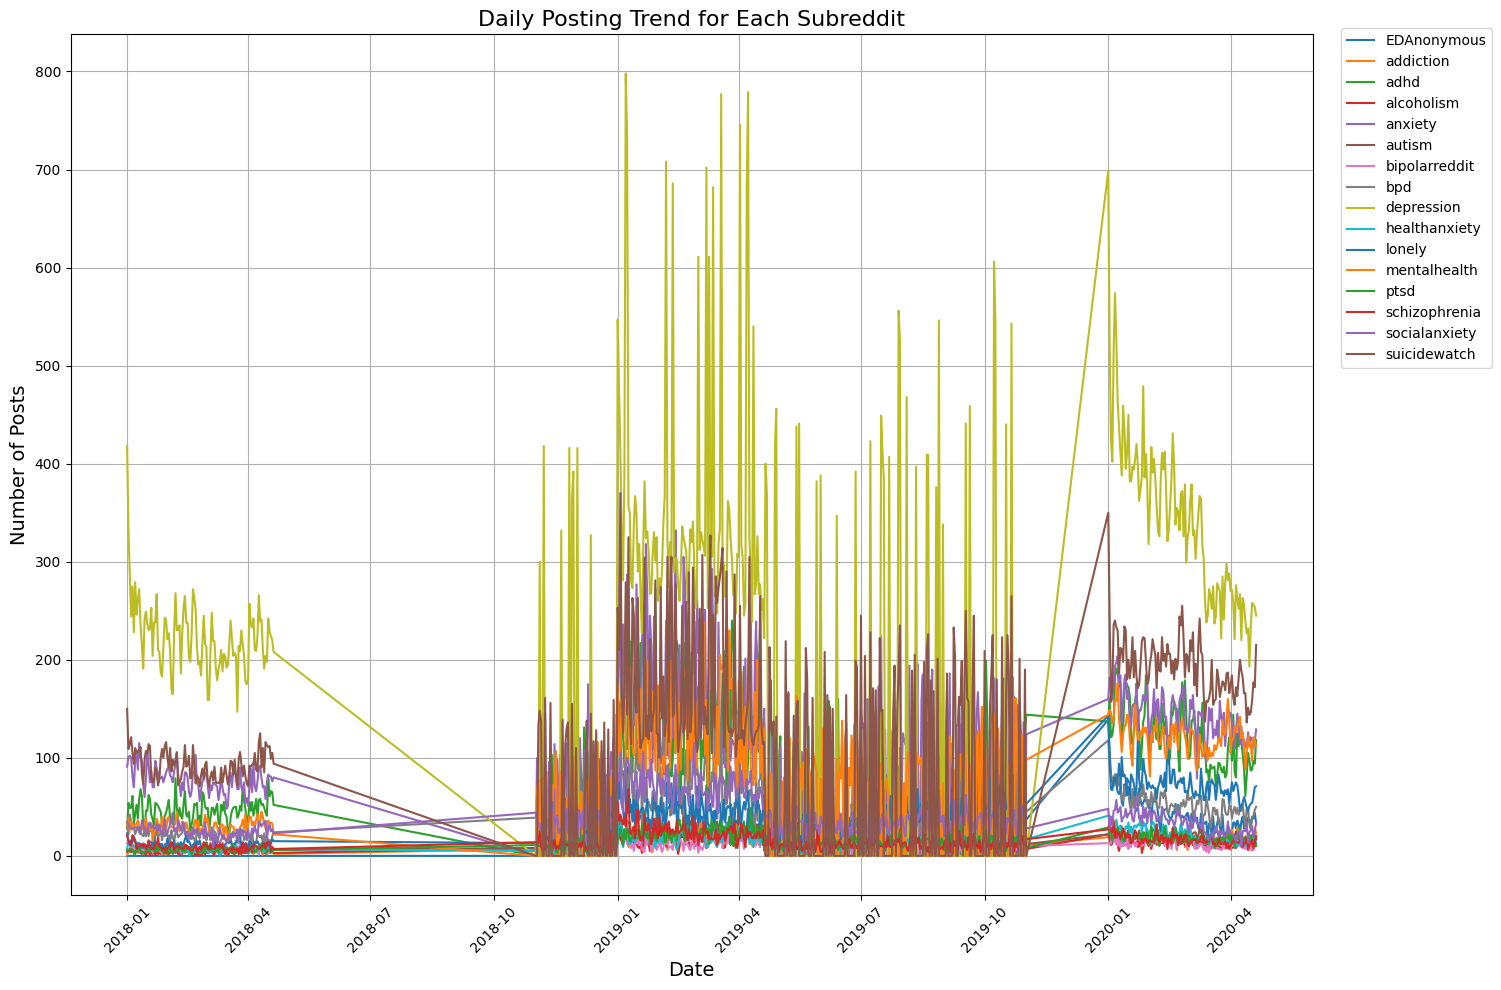

In [ ]:
#???????
# Convert 'date' column to actual date type
selected_df = df.withColumn('date', to_date(df.date, 'yyyy/MM/dd'))

# Aggregate to get daily counts for each subreddit
daily_trends = selected_df.groupBy('subreddit', 'date').count()


daily_trends_pandas = daily_trends.toPandas()


pivot_df = daily_trends_pandas.pivot(index='date', columns='subreddit', values='count').fillna(0)

# Plotting
plt.figure(figsize=(15, 10))
for subreddit in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[subreddit], label=subreddit)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)
plt.title('Daily Posting Trend for Each Subreddit', fontsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.015))
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px


pivot_df = daily_trends_pandas.pivot(index='date', columns='subreddit', values='count').fillna(0)
pivot_df.reset_index(inplace=True)
pivot_df.columns.name = None


plotly_df = pivot_df.melt(id_vars='date', var_name='subreddit', value_name='count')


fig = px.line(plotly_df, x='date', y='count', color='subreddit',
              title='Daily Posting Trend for Each Subreddit',
              labels={'count': 'Number of Posts', 'date': 'Date'})


fig.show()


In [ ]:
import pandas as pd

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


plotly_df['date'] = pd.to_datetime(plotly_df['date'])


plotly_df['month_year'] = plotly_df['date'].dt.strftime('%Y-%m')


fig = make_subplots(rows=1, cols=1)

for subreddit in plotly_df['subreddit'].unique():
    subreddit_df = plotly_df[plotly_df['subreddit'] == subreddit]
    for month_year in subreddit_df['month_year'].unique():
        # Create one trace for each month_year per subreddit
        fig.add_trace(
            go.Scatter(
                x=subreddit_df[subreddit_df['month_year'] == month_year]['date'],
                y=subreddit_df[subreddit_df['month_year'] == month_year]['count'],
                name=f"{subreddit} {month_year}"
            )
        )


buttons = []
for month_year in plotly_df['month_year'].unique():
    visibility = [month_year in trace.name for trace in fig.data]
    buttons.append(
        dict(
            label=month_year,
            method='update',
            args=[{'visible': visibility},
                  {'title': f"Posting Trend for: {month_year}"}]
        )
    )


fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            buttons=buttons
        )
    ],
    title="Daily Posting Trend for Each Subreddit"
)


fig.show()


In [ ]:
daily_trends_pandas.to_csv("/content/daily_trends.csv")

In [ ]:

import plotly.graph_objs as go
from plotly.subplots import make_subplots


daily_trends_pandas['date'] = pd.to_datetime(daily_trends_pandas['date'])


pivot_df = daily_trends_pandas.pivot(index='date', columns='subreddit', values='count').fillna(0)


fig = make_subplots(rows=1, cols=1)


for subreddit in pivot_df.columns:
    fig.add_trace(
        go.Scatter(
            x=pivot_df.index,
            y=pivot_df[subreddit],
            name=subreddit
        )
    )


buttons = [
    dict(
        label=subreddit,
        method='update',
        args=[{'visible': [subreddit == t.name for t in fig.data]}]
    )
    for subreddit in pivot_df.columns
]

buttons.append(
    dict(
        label='All',
        method='update',
        args=[{'visible': [True] * len(fig.data)}]
    )
)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            pad={'r': 10, 't': 10},
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.2,
            yanchor='top'
        ),
    ],
    showlegend=True,
    xaxis=dict(title='Date'),
    yaxis=dict(title='Number of Posts'),
    title=dict(text='Daily Posting Trend for Each Subreddit')
)

fig.show()
